# Tako HRM - MCTS Benchmark

Benchmark MCTS search performance across different configurations and games.

## What This Measures

- **MCTS searches/second** - How fast can we search game trees?
- **Forward pass time** - Neural network inference speed
- **Batching efficiency** - Speedup from batched evaluation
- **GPU vs CPU** - Device comparison
- **Game complexity** - How game size affects performance

---

## Verify Setup

**Run `setup.ipynb` first if you haven't already!**

In [34]:
# Verify setup and import libraries
import os
import sys
import torch
import yaml
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

os.chdir('/content/tako-v2')

if not os.path.exists('scripts/train.py'):
    print("❌ ERROR: Not in tako-v2 directory")
    print("   Run setup.ipynb first!")
    raise FileNotFoundError("Run setup.ipynb first")

sys.path.insert(0, os.getcwd())

from model.hrm import HRM
from training.mcts import MCTS
from games.tictactoe import TicTacToeGame
from games.othello import OthelloGame

# Detect available devices
devices = []
if torch.cuda.is_available():
    devices.append('cuda')
    print(f"✅ CUDA GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
if torch.backends.mps.is_available():
    devices.append('mps')
    print(f"✅ Apple MPS")
devices.append('cpu')
print(f"✅ CPU")

print(f"\n✅ Setup verified - ready to benchmark!")
print(f"Devices to test: {devices}")

✅ CUDA GPU: Tesla T4
   Memory: 15.6 GB
✅ CPU

✅ Setup verified - ready to benchmark!
Devices to test: ['cuda', 'cpu']


In [35]:
# Check available devices
import torch

devices = []

if torch.cuda.is_available():
    devices.append('cuda')
    print(f"✅ CUDA GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

if torch.backends.mps.is_available():
    devices.append('mps')
    print(f"✅ Apple MPS (Metal Performance Shaders)")
if devices == []:
    devices.append('cpu')
    print(f"✅ CPU")

print(f"\nDevices to benchmark: {devices}")

✅ CUDA GPU: Tesla T4
   Memory: 15.6 GB

Devices to benchmark: ['cuda']


In [36]:
def benchmark_forward_pass(game_name, device, num_trials=100, use_optimizations=False):
    """Benchmark forward pass speed with optional optimizations.
    
    Args:
        game_name: Game to benchmark ('tictactoe', 'othello')
        device: Device to use ('cuda', 'cpu', 'mps')
        num_trials: Number of trials to run
        use_optimizations: Enable torch.compile + bfloat16 + inference_mode (default: True)
    """
    # Load config
    with open(f'config/{game_name}.yaml') as f:
        config = yaml.safe_load(f)
    
    # Create model
    model = HRM(**config['model'])
    model.to(device)
    model.eval()
    
    # Apply optimizations if requested
    if use_optimizations:
        if device == 'cuda':
            dtype = torch.bfloat16
            use_compile = True
        else:
            dtype = None  # Keep float32 on CPU/MPS
            use_compile = False  # torch.compile less beneficial on CPU
        
        if dtype is not None or use_compile:
            model.optimize_for_inference(use_compile=use_compile, dtype=None)
    
    # Create game for tokens
    if game_name == 'tictactoe':
        game = TicTacToeGame()
    elif game_name == 'othello':
        game = OthelloGame()
    else:
        raise ValueError(f"Unknown game: {game_name}")
    
    tokens = game.to_tokens().unsqueeze(0).to(device)
    max_segments = config['mcts'].get('max_segments_inference', 1)
    
    # Warmup (extra warmup for torch.compile first-run compilation)
    warmup_iterations = 20 if use_optimizations else 10
    with torch.no_grad():
        for _ in range(warmup_iterations):
            policy, value, _ = model.predict(tokens, use_act=True, max_segments=max_segments)
    
    # Benchmark
    times = []
    with torch.no_grad():
        for _ in tqdm(range(num_trials), desc=f"{game_name} on {device}"):
            start = time.time()
            policy, value, _ = model.predict(tokens, use_act=True, max_segments=max_segments)
            if device == 'cuda':
                torch.cuda.synchronize()
            times.append(time.time() - start)
    
    avg_time = np.mean(times) * 1000  # Convert to ms
    std_time = np.std(times) * 1000
    
    return {
        'game': game_name,
        'device': device,
        'avg_ms': avg_time,
        'std_ms': std_time,
        'params': sum(p.numel() for p in model.parameters()) / 1e6,
        'max_segments': max_segments,
        'optimized': use_optimizations
    }

print("✅ Forward pass benchmark function ready")

✅ Forward pass benchmark function ready


In [37]:
# Run forward pass benchmarks
forward_results = []

games_to_test = ['tictactoe', 'othello']

for game in games_to_test:
    for device in devices:
        try:
            result = benchmark_forward_pass(game, device, num_trials=100)
            forward_results.append(result)
            print(f"\n{game} on {device}: {result['avg_ms']:.2f} ± {result['std_ms']:.2f} ms")
        except Exception as e:
            print(f"\n⚠️  {game} on {device} failed: {e}")

print("\n" + "="*80)
print("Forward Pass Benchmark Results:")
print("="*80)
for r in forward_results:
    print(f"{r['game']:<12} {r['device']:<6} {r['avg_ms']:>7.2f} ms  ({r['params']:.1f}M params, {r['max_segments']} seg)")

tictactoe on cuda: 100%|██████████| 100/100 [00:01<00:00, 66.46it/s]



tictactoe on cuda: 14.89 ± 8.72 ms


othello on cuda: 100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


othello on cuda: 100.76 ± 21.05 ms

Forward Pass Benchmark Results:
tictactoe    cuda     14.89 ms  (1.1M params, 1 seg)
othello      cuda    100.76 ms  (33.7M params, 1 seg)


(raylet) [2026-02-25 22:49:49,008 E 15985 15985] (raylet) node_manager.cc:3250: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 3239ea4cca05aa2aa0da395b856225b9a36d5f9e430ac65c84a62713, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) 
(raylet) [2026-02-25 22:51:49,017 E 15985 15985] (raylet) node_manager.cc:3250: 2 Workers (tasks / actors) ki

---

## Benchmark 2: MCTS Search Speed

Measure complete MCTS search including tree traversal + neural evaluations.

In [ ]:
def benchmark_mcts_search(game_name, device, num_searches=50, simulations=25):
    """Benchmark MCTS search speed."""
    # Load config
    with open(f'config/{game_name}.yaml') as f:
        config = yaml.safe_load(f)
    
    # Override simulations
    config['mcts']['simulations'] = simulations
    
    # Create model
    model = HRM(**config['model'])
    model.to(device)
    model.eval()
    
    # Create game class
    if game_name == 'tictactoe':
        game_class = TicTacToeGame
    elif game_name == 'othello':
        game_class = OthelloGame
    else:
        raise ValueError(f"Unknown game: {game_name}")
    
    # Create MCTS
    mcts = MCTS(model, game_class, config['mcts'], device=device)
    
    # Warmup
    game = game_class()
    for _ in range(5):
        _ = mcts.search(game, move_num=0)
    
    # Benchmark
    times = []
    for _ in tqdm(range(num_searches), desc=f"{game_name} MCTS on {device}"):
        game = game_class()
        start = time.time()
        policy = mcts.search(game, move_num=0)  # Returns policy distribution
        times.append(time.time() - start)
    
    avg_time = np.mean(times)
    std_time = np.std(times)
    
    return {
        'game': game_name,
        'device': device,
        'simulations': simulations,
        'avg_sec': avg_time,
        'std_sec': std_time,
        'searches_per_sec': 1.0 / avg_time,
        'batch_size': config['mcts'].get('batch_size', 1)
    }

print("✅ MCTS benchmark function ready")

In [ ]:
# Run MCTS benchmarks with default config
mcts_results = []

games_to_test = ['tictactoe', 'othello']

for game in games_to_test:
    for device in devices:
        try:
            result = benchmark_mcts_search(game, device, num_searches=50, simulations=25)
            mcts_results.append(result)
            print(f"\n{game} on {device}:")
            print(f"  {result['avg_sec']:.3f} ± {result['std_sec']:.3f} sec/search")
            print(f"  {result['searches_per_sec']:.1f} searches/sec")
        except Exception as e:
            print(f"\n⚠️  {game} on {device} failed: {e}")

print("\n" + "="*80)
print("MCTS Search Benchmark Results (25 simulations):")
print("="*80)
for r in mcts_results:
    print(f"{r['game']:<12} {r['device']:<6} {r['avg_sec']:>6.3f} s  ({r['searches_per_sec']:>6.1f} searches/s, batch={r['batch_size']})")

---

## Benchmark 3: Scaling with Simulations

How does MCTS performance scale with different numbers of simulations?

In [ ]:
# Benchmark MCTS with different simulation counts
GAME = "tictactoe"  # Change to 'othello' for larger game
DEVICE = devices[0]  # Use best available device

simulation_counts = [10, 25, 50, 100, 200, 400]
scaling_results = []

print(f"Benchmarking {GAME} on {DEVICE} with varying simulations...\n")

for sims in simulation_counts:
    result = benchmark_mcts_search(GAME, DEVICE, num_searches=30, simulations=sims)
    scaling_results.append(result)
    print(f"{sims:>4} sims: {result['avg_sec']:.3f} s ({result['searches_per_sec']:.1f} searches/s)")

print("\n✅ Scaling benchmark complete")

In [ ]:
# Plot scaling results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sims = [r['simulations'] for r in scaling_results]
times = [r['avg_sec'] for r in scaling_results]
throughput = [r['searches_per_sec'] for r in scaling_results]

# Time vs simulations
axes[0].plot(sims, times, 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('MCTS Simulations', fontsize=12)
axes[0].set_ylabel('Time per Search (seconds)', fontsize=12)
axes[0].set_title(f'{GAME.capitalize()} - Search Time vs Simulations', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

# Throughput vs simulations
axes[1].plot(sims, throughput, 'o-', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('MCTS Simulations', fontsize=12)
axes[1].set_ylabel('Searches per Second', fontsize=12)
axes[1].set_title(f'{GAME.capitalize()} - Throughput vs Simulations', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()


---

## Benchmark 4: Batching Efficiency

Compare batched vs non-batched MCTS evaluation.

In [45]:
def benchmark_batching(game_name, device, batch_sizes=[1, 4, 8, 16, 32]):
    """Benchmark different batch sizes."""
    results = []
    
    for batch_size in batch_sizes:
        # Load config
        with open(f'config/{game_name}.yaml') as f:
            config = yaml.safe_load(f)
        
        # Override batch size
        config['mcts']['batch_size'] = batch_size
        config['mcts']['simulations'] = 100  # Fixed for comparison
        
        # Create model
        model = HRM(**config['model'])
        model.to(device)
        model.eval()
        
        # Create game class
        if game_name == 'tictactoe':
            game_class = TicTacToeGame
        elif game_name == 'othello':
            game_class = OthelloGame
        
        # Create MCTS
        mcts = MCTS(model, game_class, config['mcts'], device=device)
        
        # Warmup
        game = game_class()
        for _ in range(3):
            _ = mcts.search(game, move_num=0)
        
        # Benchmark
        times = []
        for _ in range(20):
            game = game_class()
            start = time.time()
            policy = mcts.search(game, move_num=0)  # Returns policy distribution
            times.append(time.time() - start)
        
        avg_time = np.mean(times)
        results.append({
            'batch_size': batch_size,
            'avg_sec': avg_time,
            'searches_per_sec': 1.0 / avg_time
        })
        
        print(f"Batch size {batch_size:>2}: {avg_time:.3f} s ({1.0/avg_time:.1f} searches/s)")
    
    return results

print("✅ Batching benchmark function ready")

✅ Batching benchmark function ready


In [46]:
# Run batching benchmark
GAME = "tictactoe"
DEVICE = devices[0]

print(f"Benchmarking batching for {GAME} on {DEVICE}...\n")
batching_results = benchmark_batching(GAME, DEVICE, batch_sizes=[1, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048])

print("\n✅ Batching benchmark complete")

Benchmarking batching for tictactoe on cuda...

Batch size  1: 1.323 s (0.8 searches/s)
Batch size  4: 0.428 s (2.3 searches/s)
Batch size  8: 0.206 s (4.9 searches/s)
Batch size 16: 0.138 s (7.2 searches/s)
Batch size 32: 0.114 s (8.8 searches/s)
Batch size 64: 0.099 s (10.1 searches/s)
Batch size 128: 0.073 s (13.8 searches/s)
Batch size 256: 0.054 s (18.6 searches/s)
Batch size 512: 0.052 s (19.3 searches/s)
Batch size 1024: 0.051 s (19.5 searches/s)
Batch size 2048: 0.051 s (19.5 searches/s)

✅ Batching benchmark complete


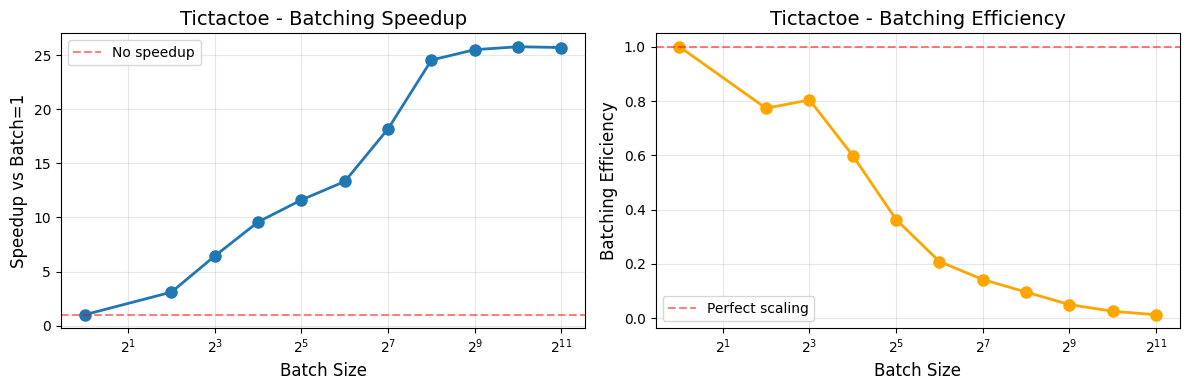


📊 Best batch size: 1024 (25.8x speedup)


In [47]:
# Plot batching efficiency
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

batch_sizes = [r['batch_size'] for r in batching_results]
times = [r['avg_sec'] for r in batching_results]
throughput = [r['searches_per_sec'] for r in batching_results]

# Speedup vs batch size
baseline_time = batching_results[0]['avg_sec']  # batch_size=1
speedups = [baseline_time / t for t in times]

axes[0].plot(batch_sizes, speedups, 'o-', linewidth=2, markersize=8)
axes[0].axhline(y=1, color='r', linestyle='--', alpha=0.5, label='No speedup')
axes[0].set_xlabel('Batch Size', fontsize=12)
axes[0].set_ylabel('Speedup vs Batch=1', fontsize=12)
axes[0].set_title(f'{GAME.capitalize()} - Batching Speedup', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_xscale('log', base=2)

# Efficiency (speedup / batch_size)
efficiency = [speedup / bs for speedup, bs in zip(speedups, batch_sizes)]
axes[1].plot(batch_sizes, efficiency, 'o-', linewidth=2, markersize=8, color='orange')
axes[1].axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Perfect scaling')
axes[1].set_xlabel('Batch Size', fontsize=12)
axes[1].set_ylabel('Batching Efficiency', fontsize=12)
axes[1].set_title(f'{GAME.capitalize()} - Batching Efficiency', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_xscale('log', base=2)

plt.tight_layout()
plt.show()

print(f"\n📊 Best batch size: {batch_sizes[speedups.index(max(speedups))]} ({max(speedups):.1f}x speedup)")

---

## Benchmark 5: End-to-End Game Generation

Measure complete game generation time (full playthrough).

In [ ]:
def benchmark_game_generation(game_name, device, num_games=20):
    """Benchmark full game generation."""
    # Load config
    with open(f'config/{game_name}.yaml') as f:
        config = yaml.safe_load(f)
    config['mcts']['batch_size'] = 2048 
    # Create model
    model = HRM(**config['model'])
    model.to(device)
    model.eval()
    
    # Create game class
    if game_name == 'tictactoe':
        game_class = TicTacToeGame
    elif game_name == 'othello':
        game_class = OthelloGame
    
    # Create MCTS
    mcts = MCTS(model, game_class, config['mcts'], device=device)
    
    # Generate games
    times = []
    move_counts = []
    
    for _ in tqdm(range(num_games), desc=f"Generating {game_name} games"):
        game = game_class()
        move_num = 0
        
        start = time.time()
        while not game.is_terminal():
            policy = mcts.search(game, move_num=move_num)  # Returns policy distribution
            # Select move from policy
            legal_moves = game.legal_moves()
            legal_policy = policy[legal_moves]
            move = legal_moves[np.argmax(legal_policy)]
            game.make_move(move)
            move_num += 1
        elapsed = time.time() - start
        
        times.append(elapsed)
        move_counts.append(move_num)
    
    avg_time = np.mean(times)
    avg_moves = np.mean(move_counts)
    games_per_hour = 3600 / avg_time
    
    return {
        'game': game_name,
        'device': device,
        'avg_time': avg_time,
        'avg_moves': avg_moves,
        'games_per_hour': games_per_hour,
        'simulations': config['mcts']['simulations']
    }

print("✅ Game generation benchmark function ready")

In [ ]:
# Run game generation benchmarks
game_gen_results = []

games_to_test = ['tictactoe', 'othello']

for game in games_to_test:
    for device in devices:
        try:
            result = benchmark_game_generation(game, device, num_games=20)
            game_gen_results.append(result)
            print(f"\n{game} on {device}:")
            print(f"  {result['avg_time']:.2f} sec/game ({result['avg_moves']:.1f} moves avg)")
            print(f"  {result['games_per_hour']:.0f} games/hour")
        except Exception as e:
            print(f"\n⚠️  {game} on {device} failed: {e}")

print("\n" + "="*80)
print("Game Generation Benchmark Results:")
print("="*80)
for r in game_gen_results:
    print(f"{r['game']:<12} {r['device']:<6} {r['avg_time']:>6.2f} s/game  ({r['games_per_hour']:>7.0f} games/hr, {r['simulations']} sims)")

In [38]:
ray.shutdown()

---

## Benchmark 6: Ray Worker Scaling (Single GPU)

Find the optimal number of Ray workers for self-play when sharing a single GPU.

**What this measures:**
- Self-play throughput (games/hour) vs number of workers
- GPU utilization and bottlenecks
- CPU vs GPU bound regions
- Optimal worker count for maximum throughput

In [39]:
from training.worker import SelfPlayWorker
import games
import os

def benchmark_ray_workers(game_name, worker_counts, games_per_worker=5, device='cuda'):
    """Benchmark self-play throughput vs number of Ray workers."""
    with open(f'config/{game_name}.yaml') as f:
        config = yaml.safe_load(f)
    
    results = []
    num_gpus = 1
    for num_workers in worker_counts:
        print(f"\n{'='*60}")
        print(f"Testing {num_workers} workers...")
        print(f"{'='*60}")
        
        # Distribute both GPU and CPU fractions evenly so Ray never gates
        # scheduling on whole-resource availability.
        cpu_fraction = (os.cpu_count() or 1) / num_workers
        if device == 'cuda':
            gpu_fraction = num_gpus / num_workers

        workers = []
        for i in range(num_workers):
            if device == 'cuda':
                worker_device = f'cuda:{i % num_gpus}'
                worker = SelfPlayWorker.options(num_gpus=gpu_fraction, num_cpus=cpu_fraction).remote(
                    worker_id=i,
                    game_class=games.TicTacToeGame,
                    model_config=config['model'],
                    mcts_config=config['mcts'],
                    opponent_pool_config={'recent_weight': 0},
                    device=worker_device
                )
            else:
                worker = SelfPlayWorker.options(num_cpus=cpu_fraction).remote(
                    worker_id=i,
                    game_class=games.TicTacToeGame,
                    model_config=config['model'],
                    mcts_config=config['mcts'],
                    opponent_pool_config={'recent_weight': 0},
                    device=device
                )
            workers.append(worker)
            if device == 'cuda':
                print(f"  Worker {i}: gpu={gpu_fraction:.4f} cpu={cpu_fraction:.4f}")
            else:
                print(f"  Worker {i}: {device} cpu={cpu_fraction:.4f}")

        # Warmup
        ray.get([w.generate_game.remote() for w in workers])
        print(f"  Warmup complete")
        
        # Benchmark
        start_time = time.time()
        worker_results = ray.get([worker.generate_batch.remote(games_per_worker) for worker in workers])
        elapsed = time.time() - start_time
        
        total_games = num_workers * games_per_worker
        total_positions = sum(len(samples) for samples in worker_results)
        avg_moves = total_positions / total_games if total_games > 0 else 0
        games_per_sec = total_games / elapsed if elapsed > 0 else 0

        result = {
            'num_workers': num_workers,
            'total_games': total_games,
            'elapsed_sec': elapsed,
            'games_per_sec': games_per_sec,
            'games_per_hour': games_per_sec * 3600,
            'positions_per_sec': total_positions / elapsed if elapsed > 0 else 0,
            'avg_moves': avg_moves
        }
        results.append(result)
        
        print(f"  Total games: {total_games}")
        print(f"  Time: {elapsed:.1f}s")
        print(f"  Throughput: {games_per_sec:.2f} games/s ({result['games_per_hour']:.0f} games/hr)")
        print(f"  Positions/sec: {result['positions_per_sec']:.1f}")
        
        for worker in workers:
            ray.kill(worker)
    
    return results

print("✅ Ray worker benchmark function ready")

✅ Ray worker benchmark function ready


In [42]:
# Run Ray worker scaling benchmark

import ray
import psutil
import multiprocessing as mp

# Check Ray availability
for _ in range(2):
    try:
        if not ray.is_initialized():
            ray.init(ignore_reinit_error=True)
        print(f"✅ Ray initialized")
        print(f"   CPU cores: {psutil.cpu_count()}")
        print(f"   Available memory: {psutil.virtual_memory().available / 1e9:.1f} GB")
        break
    except Exception as e:
        %pip install ray
        print(f"⚠️  Ray not available: {e}")



GAME = "tictactoe"  # Use tictactoe for faster iteration
DEVICE = 'cuda' if 'cuda' in devices else 'cpu'

# Test worker counts: 1, 2, 4, 8, 16, 32
# Adjust based on available CPU cores
# max_workers = min(32, psutil.cpu_count())
worker_counts = [1, 2, 4, 8]
# worker_counts = [w for w in worker_counts if w <= max_workers]

print(f"Benchmarking Ray workers for {GAME} on {DEVICE}")
print(f"Worker counts to test: {worker_counts}")
print(f"Each worker will generate 5 games per test\n")

try:
    ray_worker_results = benchmark_ray_workers(
        game_name=GAME,
        worker_counts=worker_counts,
        games_per_worker=5,
        device=DEVICE
    )
    
    print("\n" + "="*80)
    print("RAY WORKER SCALING RESULTS")
    print("="*80)
    print(f"{'Workers':<10} {'Games/sec':<12} {'Games/hour':<15} {'Positions/sec':<15}")
    print("-" * 80)
    for r in ray_worker_results:
        print(f"{r['num_workers']:<10} {r['games_per_sec']:<12.2f} {r['games_per_hour']:<15.0f} {r['positions_per_sec']:<15.1f}")
    
    print("\n✅ Ray worker benchmark complete")
except Exception as e:
    print(f"\n⚠️  Ray worker benchmark failed: {e}")
    import traceback
    traceback.print_exc()
    ray_worker_results = []

✅ Ray initialized
   CPU cores: 2
   Available memory: 1.2 GB
Benchmarking Ray workers for tictactoe on cuda
Worker counts to test: [1, 2, 4, 8]
Each worker will generate 5 games per test


Testing 1 workers...
  Worker 0: gpu=1.0000 cpu=2.0000
(SelfPlayWorker pid=66152) ✅ FlashAttention (SDPA) enabled
  Warmup complete
  Total games: 5
  Time: 2.0s
  Throughput: 2.49 games/s (8977 games/hr)
  Positions/sec: 10.5

Testing 2 workers...
  Worker 0: gpu=0.5000 cpu=1.0000
  Worker 1: gpu=0.5000 cpu=1.0000
(SelfPlayWorker pid=66280) ✅ FlashAttention (SDPA) enabled
(SelfPlayWorker pid=66281) ✅ FlashAttention (SDPA) enabled
  Warmup complete
  Total games: 10
  Time: 2.9s
  Throughput: 3.41 games/s (12262 games/hr)
  Positions/sec: 15.3

Testing 4 workers...
  Worker 0: gpu=0.2500 cpu=0.5000
  Worker 1: gpu=0.2500 cpu=0.5000
  Worker 2: gpu=0.2500 cpu=0.5000
  Worker 3: gpu=0.2500 cpu=0.5000
(SelfPlayWorker pid=66469) ✅ FlashAttention (SDPA) enabled
(SelfPlayWorker pid=66395) ✅ FlashAttention

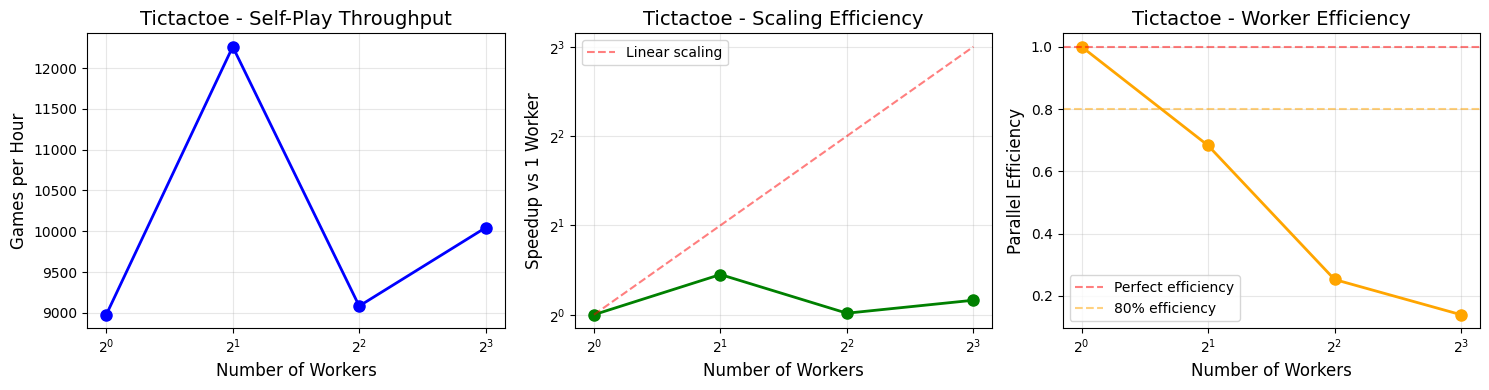


📊 Optimal Configuration:
  Workers: 1
  Throughput: 8977 games/hour
  Speedup: 1.0x
  Efficiency: 100.0%


In [44]:
# Plot Ray worker scaling results
if ray_worker_results:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    workers = [r['num_workers'] for r in ray_worker_results]
    throughput = [r['games_per_hour'] for r in ray_worker_results]
    positions_per_sec = [r['positions_per_sec'] for r in ray_worker_results]
    
    # Calculate speedup vs single worker
    baseline_throughput = ray_worker_results[0]['games_per_hour']
    speedups = [t / baseline_throughput for t in throughput]
    efficiency = [speedup / w for speedup, w in zip(speedups, workers)]
    
    # Plot 1: Throughput vs workers
    axes[0].plot(workers, throughput, 'o-', linewidth=2, markersize=8, color='blue')
    axes[0].set_xlabel('Number of Workers', fontsize=12)
    axes[0].set_ylabel('Games per Hour', fontsize=12)
    axes[0].set_title(f'{GAME.capitalize()} - Self-Play Throughput', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xscale('log', base=2)
    
    # Plot 2: Speedup vs workers
    axes[1].plot(workers, speedups, 'o-', linewidth=2, markersize=8, color='green')
    axes[1].plot(workers, workers, '--', alpha=0.5, color='red', label='Linear scaling')
    axes[1].set_xlabel('Number of Workers', fontsize=12)
    axes[1].set_ylabel('Speedup vs 1 Worker', fontsize=12)
    axes[1].set_title(f'{GAME.capitalize()} - Scaling Efficiency', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    axes[1].set_xscale('log', base=2)
    axes[1].set_yscale('log', base=2)
    
    # Plot 3: Parallel efficiency
    axes[2].plot(workers, efficiency, 'o-', linewidth=2, markersize=8, color='orange')
    axes[2].axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Perfect efficiency')
    axes[2].axhline(y=0.8, color='orange', linestyle='--', alpha=0.5, label='80% efficiency')
    axes[2].set_xlabel('Number of Workers', fontsize=12)
    axes[2].set_ylabel('Parallel Efficiency', fontsize=12)
    axes[2].set_title(f'{GAME.capitalize()} - Worker Efficiency', fontsize=14)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    axes[2].set_xscale('log', base=2)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal worker count (best efficiency above 80% or max throughput)
    optimal_idx = -1
    for i, (eff, w) in enumerate(zip(efficiency, workers)):
        if eff >= 0.8:
            optimal_idx = i
        else:
            break
    
    if optimal_idx >= 0:
        optimal_workers = workers[optimal_idx]
        optimal_throughput = throughput[optimal_idx]
        optimal_speedup = speedups[optimal_idx]
        
        print(f"\n📊 Optimal Configuration:")
        print(f"  Workers: {optimal_workers}")
        print(f"  Throughput: {optimal_throughput:.0f} games/hour")
        print(f"  Speedup: {optimal_speedup:.1f}x")
        print(f"  Efficiency: {efficiency[optimal_idx]*100:.1f}%")
    else:
        # Just use max throughput
        max_idx = throughput.index(max(throughput))
        print(f"\n📊 Best Performance:")
        print(f"  Workers: {workers[max_idx]}")
        print(f"  Throughput: {throughput[max_idx]:.0f} games/hour")
        print(f"  Speedup: {speedups[max_idx]:.1f}x")
else:
    print("⚠️  No Ray worker results to plot")

---

## Export Results

Save benchmark results for future reference.

In [ ]:
# Save results to file
import json
from datetime import datetime

results = {
    'timestamp': datetime.now().isoformat(),
    'devices': devices,
    'forward_pass': forward_results,
    'mcts_search': mcts_results,
    'game_generation': game_gen_results,
    'scaling': scaling_results if 'scaling_results' in dir() else [],
    'batching': batching_results if 'batching_results' in dir() else [],
    'ray_workers': ray_worker_results if 'ray_worker_results' in dir() and ray_worker_results else []
}

output_file = f"benchmark_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(output_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"✅ Results saved to: {output_file}")
print(f"\nFile size: {Path(output_file).stat().st_size / 1024:.1f} KB")